# <span style="color:darkred"><ins>Detection of defects in steelmaking</ins></span>

We have to automate the process of detecting defects in the manufacture of steel. Detection of defects will help improve the steel quality, as well as reduce waste due to production defects.

The company has been provided us 12,600 images of steel surfaces. Each image contains 4 different types of defect, where we can also see their location in the images.

#  1- Import libraries and dataset

In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import zipfile
import cv2
from skimage import io
import tensorflow as tf
from tensorflow.python.keras import Sequential
from tensorflow.keras import layers, optimizers
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
from IPython.display import display
from tensorflow.keras import backend as K
from sklearn.preprocessing import StandardScaler, normalize
import os

**- Loading data with manufacturing defects:**

In [6]:
defect_df = pd.read_csv('train.csv')

In [8]:
defect_df

,ImageId,ClassId,EncodedPixels
0,d2291de5c.jpg,1,147963 3 148213 9 148461 18 148711 24 148965 2...
1,78416c3d0.jpg,3,54365 3 54621 7 54877 10 55133 12 55388 14 556...
2,2283f2183.jpg,3,201217 43 201473 128 201729 213 201985 5086 20...
3,f0dc068a8.jpg,3,159207 26 159412 77 159617 128 159822 179 1600...
4,00d639396.jpg,3,229356 17 229595 34 229850 36 230105 37 230360...
...,...,...,...
5743,c12842f5e.jpg,3,88 23 342 29 596 34 850 39 1105 44 1361 46 161...
5744,2222a03b3.jpg,3,63332 4 63587 11 63841 20 64096 27 64351 35 64...
5745,b43ea2c01.jpg,1,185024 7 185279 11 185535 12 185790 13 186045 ...
5746,1bc37a6f4.jpg,3,303867 1 304122 3 304376 6 304613 3 304630 9 3...


**- We load the data with and without defects:**

In [7]:
all_df = pd.read_csv('defect_and_no_defect.csv')

In [9]:
all_df

,ImageID,label
0,0002cc93b.jpg,1
1,0007a71bf.jpg,1
2,000a4bcdd.jpg,1
3,000f6bf48.jpg,1
4,0014fce06.jpg,1
...,...,...
12992,0482ee1d6.jpg,0
12993,04802a6c2.jpg,0
12994,03ae2bc91.jpg,0
12995,04238d7e3.jpg,0


# 2 - Data Visualization

**- Let's create a new column for the mask:**

In [10]:
defect_df['mask'] = defect_df['ClassId'].map(lambda x: 1)

In [11]:
defect_df.head(50)

,ImageId,ClassId,EncodedPixels,mask
0,d2291de5c.jpg,1,147963 3 148213 9 148461 18 148711 24 148965 2...,1
1,78416c3d0.jpg,3,54365 3 54621 7 54877 10 55133 12 55388 14 556...,1
2,2283f2183.jpg,3,201217 43 201473 128 201729 213 201985 5086 20...,1
3,f0dc068a8.jpg,3,159207 26 159412 77 159617 128 159822 179 1600...,1
4,00d639396.jpg,3,229356 17 229595 34 229850 36 230105 37 230360...,1
5,17d02873a.jpg,3,254980 43 255236 127 255492 211 255748 253 256...,1
6,47b5ab1bd.jpg,3,128976 8 129230 12 129484 16 129739 23 129995 ...,1
7,a6ecee828.jpg,3,179011 27 179126 73 179259 39 179375 80 179497...,1
8,11aaf18e2.jpg,3,303235 2 303489 7 303743 9 303997 11 304181 2 ...,1
9,cdf669a1f.jpg,4,310246 11 310499 25 310753 28 311007 31 311262...,1


Text(0.5, 1.0, 'Number of images per class')

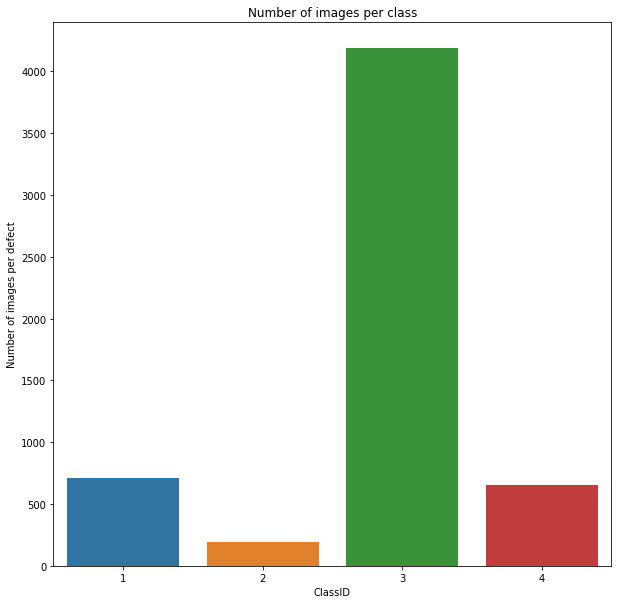

In [12]:
plt.figure(figsize=(10,10))
sns.countplot(defect_df['ClassId'])
plt.ylabel('Number of images per defect')
plt.xlabel('ClassID')
plt.title('Number of images per class')

Type 3 defect is the most common.

**- Some images are classified with more than one defect, let's explore this point in detail:**

In [13]:
defect_type = defect_df.groupby(['ImageId'])['mask'].sum()

In [14]:
defect_type

ImageId
0002cc93b.jpg    1
0007a71bf.jpg    1
000a4bcdd.jpg    1
000f6bf48.jpg    1
0014fce06.jpg    1
                ..
ffcf72ecf.jpg    1
fff02e9c5.jpg    1
fffe98443.jpg    1
ffff4eaa8.jpg    1
ffffd67df.jpg    1
Name: mask, Length: 5474, dtype: int64

In [15]:
defect_type.value_counts()

1    5201
2     272
3       1
Name: mask, dtype: int64

* We have an image with 3 types of defects.
* 272 images with 2 types of defects.
* 5201 images with 1 type of defect.

Text(0.5, 1.0, 'Number of defects in image')

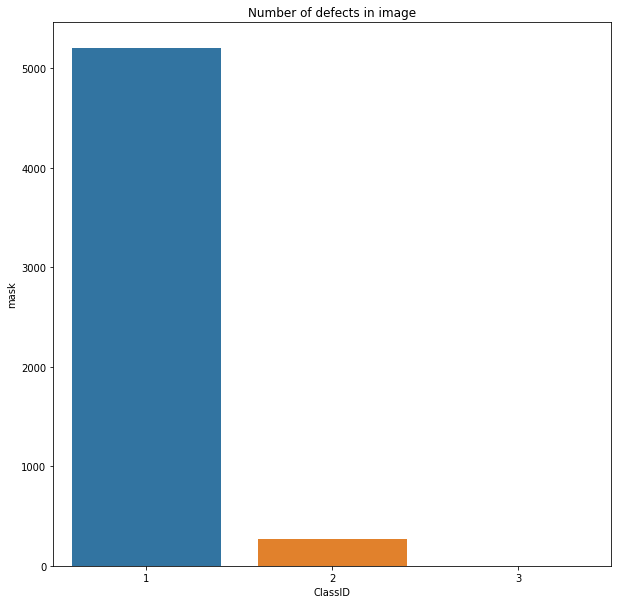

In [16]:
plt.figure(figsize=(10,10))
sns.barplot(x = defect_type.value_counts().index, y = defect_type.value_counts() )
plt.xlabel('ClassID')
plt.title('Number of defects in image')

In [17]:
defect_df.shape

(5748, 4)

In [18]:
all_df.shape

(12997, 2)

**- Number of images with and whitout defects:**

In [19]:
# Contemos imágenes con y sin defectos
all_df.label.value_counts()

1    7095
0    5902
Name: label, dtype: int64

Text(0.5, 1.0, 'Defect and non-defect images')

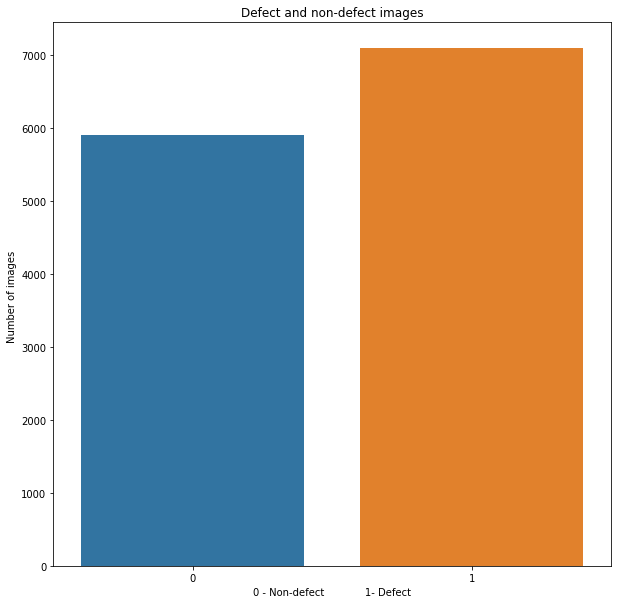

In [20]:
plt.figure(figsize=(10,10))
sns.barplot(x = all_df.label.value_counts().index, y = all_df.label.value_counts() )
plt.ylabel('Number of images ')
plt.xlabel('0 - Non-defect             1- Defect')
plt.title('Defect and non-defect images')

**- Let's load and visualize the images together with their defect type labels:**

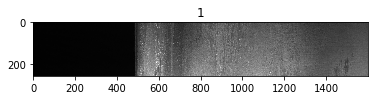

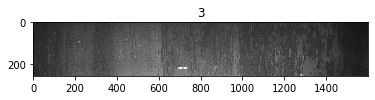

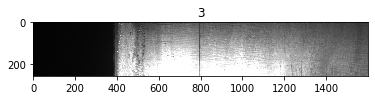

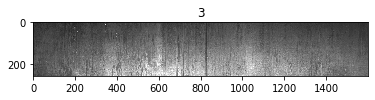

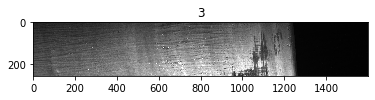

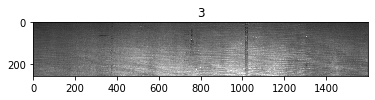

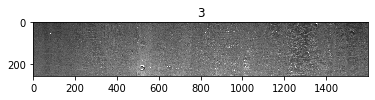

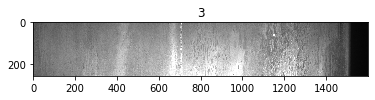

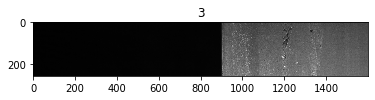

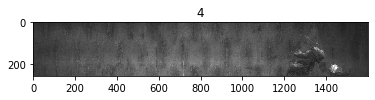

In [21]:
train_dir = 'train_images'

for i in range(10):
  img = io.imread(os.path.join(train_dir, defect_df.ImageId[i]))
  plt.figure()
  plt.title(defect_df.ClassId[i])
  plt.imshow(img)

# 3 - Masks

* First we're going to import *Utilities*. This file contains the code for *rle2mask*, *mask2rle*, custom loss function and custom data generator, respectively.

* Since the data provided for the segmentation is in RLE (*Run Length Encoded*) format, we'll use the following function to convert the RLE to a mask. We can convert the mask back to RLE to evaluate the accuracy of the model.

**Source code of these functions:** https://www.kaggle.com/paulorzp/rle-functions-run-lenght-encode-decode

In [23]:
defect_df

,ImageId,ClassId,EncodedPixels,mask
0,d2291de5c.jpg,1,147963 3 148213 9 148461 18 148711 24 148965 2...,1
1,78416c3d0.jpg,3,54365 3 54621 7 54877 10 55133 12 55388 14 556...,1
2,2283f2183.jpg,3,201217 43 201473 128 201729 213 201985 5086 20...,1
3,f0dc068a8.jpg,3,159207 26 159412 77 159617 128 159822 179 1600...,1
4,00d639396.jpg,3,229356 17 229595 34 229850 36 230105 37 230360...,1
...,...,...,...,...
5743,c12842f5e.jpg,3,88 23 342 29 596 34 850 39 1105 44 1361 46 161...,1
5744,2222a03b3.jpg,3,63332 4 63587 11 63841 20 64096 27 64351 35 64...,1
5745,b43ea2c01.jpg,1,185024 7 185279 11 185535 12 185790 13 186045 ...,1
5746,1bc37a6f4.jpg,3,303867 1 304122 3 304376 6 304613 3 304630 9 3...,1


### Test image

**- Let's try using rle2mask in a test image (we go from encoding to mask format):**

In [24]:
from utilities import rle2mask , mask2rle

image_index = 20 #20 30
mask = rle2mask(defect_df.EncodedPixels[image_index], img.shape[0], img.shape[1]) 
# [0] of 256 rows and [1] of 1600 columns. 
#The mask will give us a reordered mask. We load a huge strip with 0s and 1s encoded, the 'rle2mask' will place a row with 0s and 1s first, and secondly it will build a two-dimensional row
mask.shape

(256, 1600)

**- Let's see the mask:**

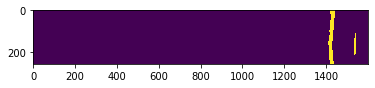

In [25]:
# Veamos la máscara
plt.imshow(mask)

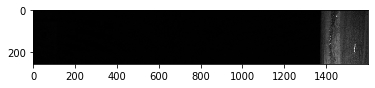

(256, 1600, 3)

In [26]:
img = io.imread(os.path.join(train_dir, defect_df.ImageId[image_index]))
plt.imshow(img)
plt.show()
img.shape

### Real images

**- We mark the defect with the green channel to 255:**

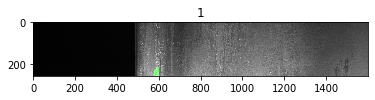

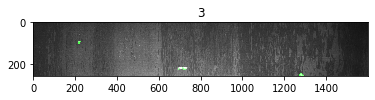

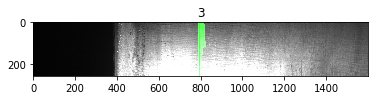

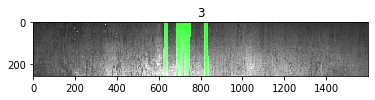

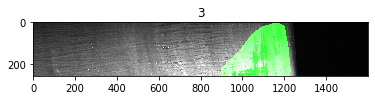

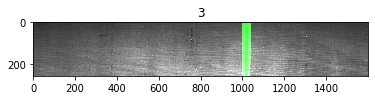

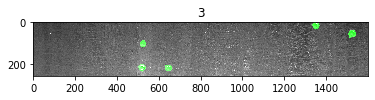

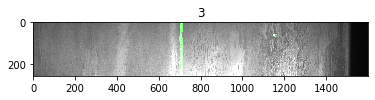

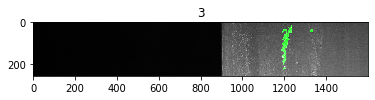

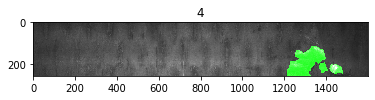

In [27]:
for i in range(10):
  # Read the images using opencv and converting to rgb format
  img = io.imread(os.path.join(train_dir, defect_df.ImageId[i]))
  # read the image with cv2 and convert it to color channel
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  # load the mask from rle
  mask = rle2mask(defect_df.EncodedPixels[i], img.shape[0], img.shape[1])
  # We draw the pixel color with value = 1 (defect) to the color 255 (the maximum possible) for channel 1 (green)
  img[mask == 1,1] = 255
  plt.figure()
  plt.imshow(img)
  plt.title(defect_df.ClassId[i])

# 4 - Building and training a deep learning model

In [28]:
all_df

,ImageID,label
0,0002cc93b.jpg,1
1,0007a71bf.jpg,1
2,000a4bcdd.jpg,1
3,000f6bf48.jpg,1
4,0014fce06.jpg,1
...,...,...
12992,0482ee1d6.jpg,0
12993,04802a6c2.jpg,0
12994,03ae2bc91.jpg,0
12995,04238d7e3.jpg,0


**- We split the dataset into 15% for testing and 85% for training:**

In [29]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(all_df, test_size=0.15)

In [30]:
train.shape

(11047, 2)

In [31]:
test.shape

(1950, 2)

In [32]:
train_dir = 'train_images'

**- We make an image generator for the dataset for both training and validation:**

In [33]:
# Training = 9390 
# validation = 1657 
# testing = 1950 

from keras_preprocessing.image import ImageDataGenerator

# scale data from 0 to 1 and make a validation division of 0,15
datagen = ImageDataGenerator(rescale=1./255., validation_split = 0.15)

train_generator = datagen.flow_from_dataframe(
dataframe = train,
directory = train_dir,
x_col = "ImageID",
y_col = "label",
subset = "training",
batch_size = 16,
shuffle = True,
class_mode = "other",
target_size = (256, 256))


valid_generator = datagen.flow_from_dataframe(
dataframe = train,
directory = train_dir,
x_col = "ImageID",
y_col = "label",
subset = "validation",
batch_size = 16,
shuffle = True,
class_mode = "other",
target_size = (256, 256))


Found 9390 validated image filenames.
Found 1657 validated image filenames.


**- Create a data generator for test images:**

In [34]:
test_datagen = ImageDataGenerator(rescale=1./255.)

test_generator = test_datagen.flow_from_dataframe(
dataframe = test,
directory = train_dir,
x_col = "ImageID",
y_col = None,
batch_size = 16,
shuffle = False,
class_mode = None,
target_size = (256, 256))



Found 1950 validated image filenames.


**- We load the pre-trained base model of the 'REsNet50' network using the imagenet weights:**

***Source:*** *https://www.kaggle.com/keras/resnet50*

In [35]:
basemodel = ResNet50(weights = 'imagenet', include_top = False, input_tensor = Input(shape=(256,256,3)))

In [36]:
basemodel.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 262, 262, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 128, 128, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 128, 128, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

**- Freezing the model weights:**

In [37]:
for layer in basemodel.layers:
  layers.trainable = False

In [38]:
headmodel = basemodel.output
headmodel = AveragePooling2D(pool_size = (4,4))(headmodel)
headmodel = Flatten(name= 'flatten')(headmodel)
headmodel = Dense(256, activation = "relu")(headmodel)
headmodel = Dropout(0.3)(headmodel)
headmodel = Dense(1, activation = 'sigmoid')(headmodel)

model = Model(inputs = basemodel.input, outputs = headmodel)

In [39]:
model.compile(loss = 'binary_crossentropy', optimizer='Nadam', metrics= ["accuracy"])

**- We can use the 'early stop' to stop the training to avoid overfitting (if the validation loss does not go down after a certain number of epochs):**

In [40]:
earlystopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

# We keep the model with the least validation error
checkpointer = ModelCheckpoint(filepath="resnet-weights.hdf5", verbose=1, save_best_only=True)

In [43]:
#  we careful, this step lasts at least 90min (in our PC)
history = model.fit_generator(train_generator, steps_per_epoch= train_generator.n // 16, epochs = 40, validation_data= valid_generator, validation_steps= valid_generator.n // 16, callbacks=[checkpointer, earlystopping])

**- We save the architecture of the trained model for the future:**

In [42]:
model_json = model.to_json()
with open("resnet-classifier-model.json","w") as json_file:
  json_file.write(model_json)

# 5 - Evaluate the effectiveness of the model

In [45]:
with open('resnet-classifier-model.json', 'r') as json_file:
    json_savedModel= json_file.read()
# load the model 
model = tf.keras.models.model_from_json(json_savedModel)
model.load_weights('weights.hdf5')
model.compile(loss = 'binary_crossentropy', optimizer='Nadam', metrics= ["accuracy"])

**- We make the prediction:**

In [46]:
from keras_preprocessing.image import ImageDataGenerator

test_predict = model.predict(test_generator, steps = test_generator.n // 16, verbose =1)

121/121 [==============================] - 219s 2s/step


* Since we use at the end the sigmoid activation function, our result contains continuous values from 0 to 1.
* The network is initially used to classify whether the image is defective or not
* These defective images are then passed through the segmentation network to obtain the location and type of defect.
* We're going to choose 0.01, to make sure we skip the images so they don't go through the segmentation network unless
* That it does not have any defect and if we are not sure, we can pass this image through the segmentation network.

In [47]:
predict = []

for i in test_predict:
  if i < 0.01: #0.5
    predict.append(0)
  else:
    predict.append(1)

predict = np.asarray(predict)

In [48]:
len(predict)

1936

In [49]:
# we used the test generator, it limited the images to 1936, due to batch size
original = np.asarray(test.label)[:1936]
len(original)

1936

**- We look for the accuracy of the model:**

In [50]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(original, predict)
accuracy

0.8693181818181818

**- Matrix Confusion and classification report:**

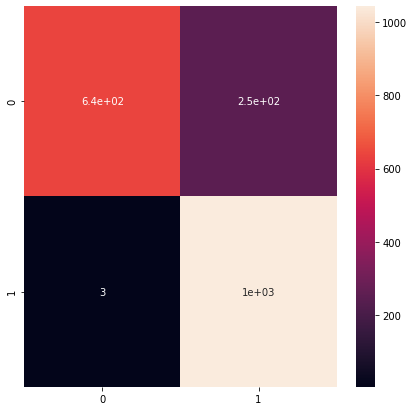

In [51]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(original, predict)
plt.figure(figsize = (7,7))
sns.heatmap(cm, annot=True)

In [52]:
# Imprimimos el reporte de clasificación

from sklearn.metrics import classification_report

report = classification_report(original,predict, labels = [0,1])
print(report)

              precision    recall  f1-score   support

           0       1.00      0.72      0.83       889
           1       0.81      1.00      0.89      1047

    accuracy                           0.87      1936
   macro avg       0.90      0.86      0.86      1936
weighted avg       0.89      0.87      0.87      1936



We have a good precision for the defects (0,81)

# 6 - Build a segmentation model with ResUNet

**Source:** https://github.com/nikhilroxtomar/Deep-Residual-Unet

In [53]:
from sklearn.model_selection import train_test_split

X_train, X_val = train_test_split(defect_df, test_size=0.2)

**- Create separate list to pass to generator for imageId, classId and RLE:**

In [54]:
train_ids = list(X_train.ImageId)
train_class = list(X_train.ClassId)
train_rle = list(X_train.EncodedPixels)

val_ids = list(X_val.ImageId)
val_class = list(X_val.ClassId)
val_rle = list(X_val.EncodedPixels)

**- Creating images generator:**

In [55]:
from utilities import DataGenerator

training_generator = DataGenerator(train_ids,train_class, train_rle, train_dir)
validation_generator = DataGenerator(val_ids,val_class,val_rle, train_dir)

In [56]:
def resblock(X, f):
  
  # Entry copy
  X_copy = X

  # Main Path
  # https://medium.com/@prateekvishnu/xavier-and-he-normal-he-et-al-initialization-8e3d7a087528

  X = Conv2D(f, kernel_size = (1,1), strides = (1,1), kernel_initializer ='he_normal')(X)
  X = BatchNormalization()(X)
  X = Activation('relu')(X) 

  X = Conv2D(f, kernel_size = (3,3), strides =(1,1), padding = 'same', kernel_initializer ='he_normal')(X)
  X = BatchNormalization()(X)

  # Short Path
  # https://towardsdatascience.com/understanding-and-coding-a-resnet-in-keras-446d7ff84d33

  X_copy = Conv2D(f, kernel_size = (1,1), strides =(1,1), kernel_initializer ='he_normal')(X_copy)
  X_copy = BatchNormalization()(X_copy)

  # We add the output file from the combination of main and short path
  
  X = Add()([X,X_copy])
  X = Activation('relu')(X)

  return X

**- Create a upscale function and join the values:**

In [57]:
def upsample_concat(x, skip):
  x = UpSampling2D((2,2))(x)
  merge = Concatenate()([x, skip])

  return merge

In [58]:
input_shape = (256,256,1)

#Input tensor shape
X_input = Input(input_shape)

#Stage 1
conv1_in = Conv2D(16,3,activation= 'relu', padding = 'same', kernel_initializer ='he_normal')(X_input)
conv1_in = BatchNormalization()(conv1_in)
conv1_in = Conv2D(16,3,activation= 'relu', padding = 'same', kernel_initializer ='he_normal')(conv1_in)
conv1_in = BatchNormalization()(conv1_in)
pool_1 = MaxPool2D(pool_size = (2,2))(conv1_in)

#Stage 2
conv2_in = resblock(pool_1, 32)
pool_2 = MaxPool2D(pool_size = (2,2))(conv2_in)

#Stage 3
conv3_in = resblock(pool_2, 64)
pool_3 = MaxPool2D(pool_size = (2,2))(conv3_in)

#Stage 4
conv4_in = resblock(pool_3, 128)
pool_4 = MaxPool2D(pool_size = (2,2))(conv4_in)

#Stage 5
conv5_in = resblock(pool_4, 256)

#Upscale stage 1
up_1 = upsample_concat(conv5_in, conv4_in)
up_1 = resblock(up_1, 128)

#Upscale stage 2
up_2 = upsample_concat(up_1, conv3_in)
up_2 = resblock(up_2, 64)

#Upscale stage 3
up_3 = upsample_concat(up_2, conv2_in)
up_3 = resblock(up_3, 32)

#Upscale stage 4
up_4 = upsample_concat(up_3, conv1_in)
up_4 = resblock(up_4, 16)

#Final Output
output = Conv2D(4, (1,1), padding = "same", activation = "sigmoid")(up_4)

model_seg = Model(inputs = X_input, outputs = output )


### Loss function

**Source:** https://github.com/nabsabraham/focal-tversky-unet/blob/master/losses.py

**- We need a custom loss function to train this ResUNet:**

In [60]:
#%cd /content/drive/My Drive/Curso de Data Science para Empresas/6. Maintenance Department

from utilities import focal_tversky, tversky_loss, tversky

In [61]:
adam = tf.keras.optimizers.Adam(lr = 0.05, epsilon = 0.1)
model_seg.compile(optimizer = adam, loss = focal_tversky, metrics = [tversky])

In [62]:
# use to exit training the 'early stop' if validation loss does not decrease even after certain epochs (be patient)
earlystopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

# Keep the best model with the least loss of validation
checkpointer = ModelCheckpoint(filepath="resunet-segmentation-weights.hdf5", verbose=1, save_best_only=True)

**- We save the model for future:**

In [64]:
model_json = model_seg.to_json()
with open("resunet-segmentation-model.json","w") as json_file:
  json_file.write(model_json)

# 7 - The effectiveness of the trained segmentation model

In [76]:
from utilities import focal_tversky, tversky_loss, tversky

with open('resunet-segmentation-model.json', 'r') as json_file:
    json_savedModel= json_file.read()

# Load the model
model_seg = tf.keras.models.model_from_json(json_savedModel)
model_seg.load_weights('weights_seg.hdf5')
adam = tf.keras.optimizers.Adam(lr = 0.05, epsilon = 0.1)
model_seg.compile(optimizer = adam, loss = focal_tversky, metrics = [tversky])

**- Test data for the segmentation task:**

In [77]:
test_df = pd.read_csv('test.csv')

In [78]:
test_df

,ImageId,ClassId,EncodedPixels
0,0ca915b9f.jpg,3,188383 3 188637 5 188892 6 189148 5 189403 6 1...
1,7773445b7.jpg,3,75789 33 76045 97 76300 135 76556 143 76811 15...
2,5e0744d4b.jpg,3,120323 91 120579 182 120835 181 121091 181 121...
3,6ccde604d.jpg,3,295905 32 296098 95 296290 159 296483 222 2967...
4,16aabaf79.jpg,1,352959 24 353211 28 353465 31 353719 33 353973...
...,...,...,...
633,a4334d7da.jpg,4,11829 7 12073 20 12317 32 12566 40 12821 41 13...
634,418e47222.jpg,3,46340 43 46596 127 46852 211 47108 253 47364 2...
635,817a545aa.jpg,3,206529 64 206657 4518 211201 179 211457 128 21...
636,caad490a5.jpg,3,59631 10 59867 30 60103 50 60339 69 60585 79 6...


In [80]:
test_df.ImageId

0      0ca915b9f.jpg
1      7773445b7.jpg
2      5e0744d4b.jpg
3      6ccde604d.jpg
4      16aabaf79.jpg
           ...      
633    a4334d7da.jpg
634    418e47222.jpg
635    817a545aa.jpg
636    caad490a5.jpg
637    a5e9195b6.jpg
Name: ImageId, Length: 638, dtype: object

**- Prediction:**

In [81]:
from utilities import prediction

image_id, defect_type, mask = prediction(test_df, model, model_seg)

**- We create the dataframe for the result:**

In [82]:
df_pred= pd.DataFrame({'ImageId': image_id,'EncodedPixels': mask,'ClassId': defect_type})
df_pred.head()

,ImageId,EncodedPixels,ClassId
0,0ca915b9f.jpg,151421 1 151423 2 151677 1 151679 2 151933 1 1...,3
1,7773445b7.jpg,72927 2 73183 2 73439 2 73695 2 73951 2 74207 ...,3
2,5e0744d4b.jpg,116095 2 116351 2 116607 2 116863 2 117119 2 1...,3
3,6ccde604d.jpg,290305 4 290561 4 290817 4 291073 4 291329 4 2...,3
4,16aabaf79.jpg,352937 24 353193 24 353449 24 353705 24 353961...,3


**- We are going to show the images together with their original masks (ground truth):**

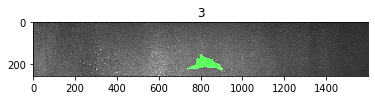

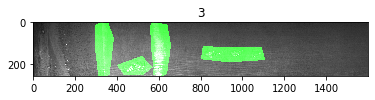

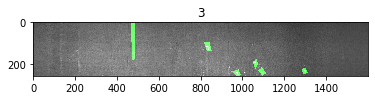

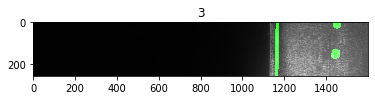

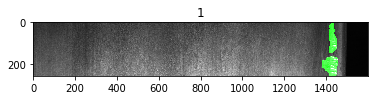

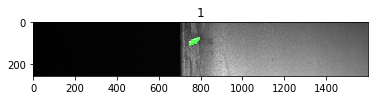

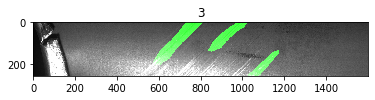

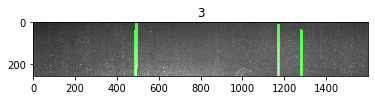

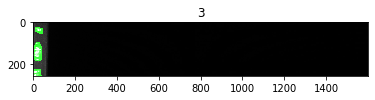

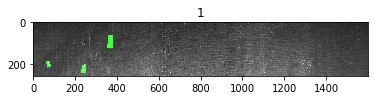

In [83]:
# Vamos a mostrar las imágenes junto con sus máscaras originales (ground truth)
for i in range(10):

  # read the images using opencv and convert them to rgb format
  img = io.imread(os.path.join(train_dir,test_df.ImageId[i]))
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

  # Get mask for rle image
  mask = rle2mask(test_df.EncodedPixels[i],img.shape[0],img.shape[1])

  img[mask == 1,1] = 255
  plt.figure()
  plt.title(test_df.ClassId[i])
  plt.imshow(img)

**- Visualize the results (model predictions):**

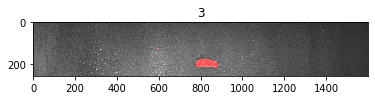

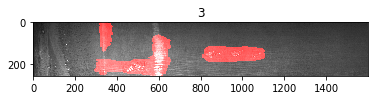

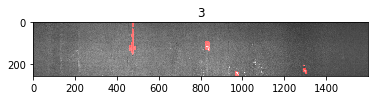

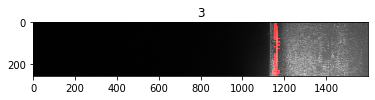

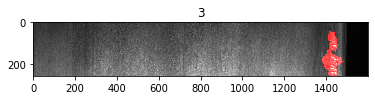

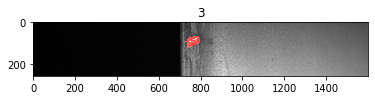

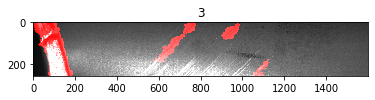

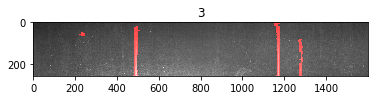

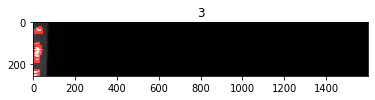

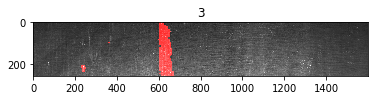

In [84]:
directory = "train_images"

for i in range(10):

  # read the images using opencv and convert them to rgb format
  img = io.imread(os.path.join(directory,df_pred.ImageId[i]))
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

   # Get mask for rle image
  mask = rle2mask(df_pred.EncodedPixels[i],img.shape[0],img.shape[1])
  
  img[mask == 1,0] = 255
  plt.figure()
  plt.title(df_pred.ClassId[i])
  plt.imshow(img)